# 🚦 LightGBM Starter for Playground Series S5E10

This notebook provides a clean baseline model using LightGBM.  
It includes minimal preprocessing, a few visualizations, and a simple cross-validation setup.  
The goal is to give others a solid starting point for further improvements.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Load datasets
train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

# Define target and ID column names
TARGET = "accident_risk"
ID = "id"

## 📊 Quick Look at the Data
Let's take a look at the shape of the training and test sets, and preview a few rows.

In [2]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (517754, 14)
Test shape: (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


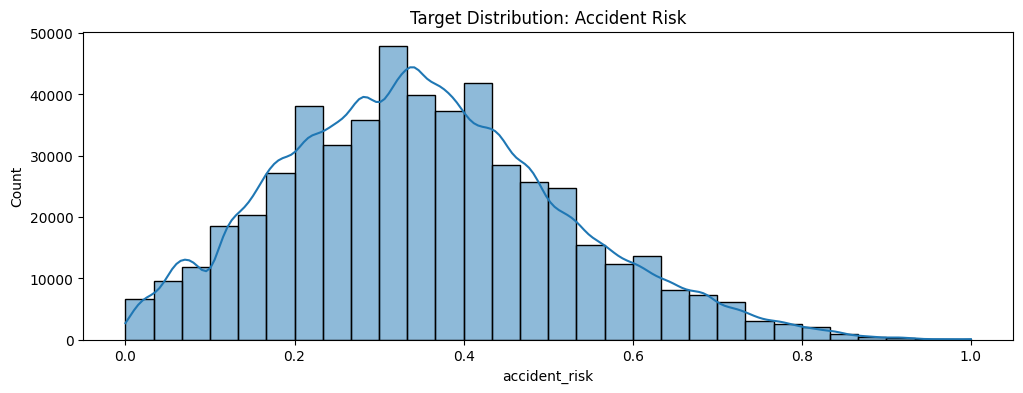

In [3]:
# Plot the distribution of the target variable
plt.figure(figsize=(12,4))
sns.histplot(train[TARGET], kde=True, bins=30)
plt.title("Target Distribution: Accident Risk")
plt.show()

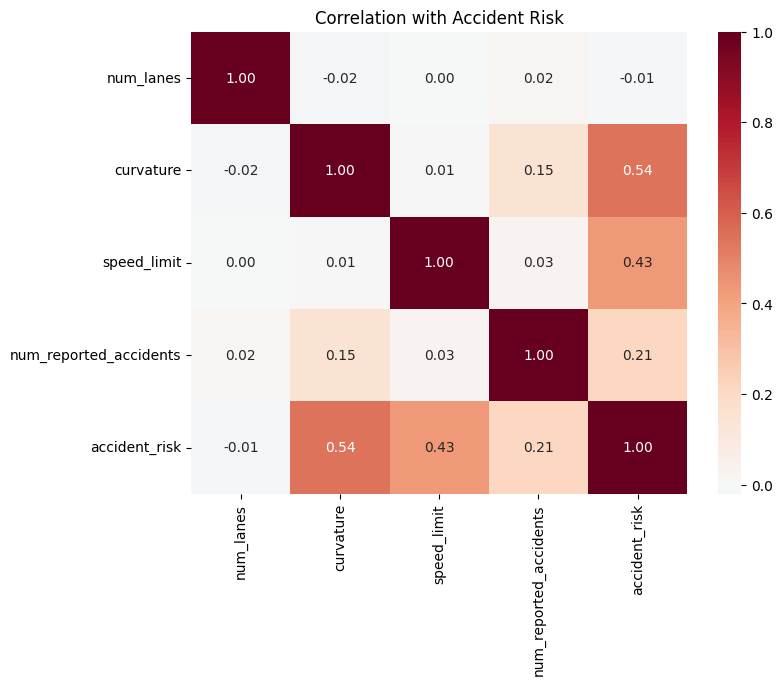

In [4]:
# Identify categorical and numerical columns
cat_cols = train.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols = [col for col in train.columns if col not in cat_cols + [TARGET, ID]]

# Quick correlation heatmap for numerical features vs target
plt.figure(figsize=(8,6))
sns.heatmap(train[num_cols+[TARGET]].corr(), annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation with Accident Risk")
plt.show()

## 🛠️ Preprocessing
- Label encoding for categorical features  
- Standardization for numerical features

In [5]:
# Function to label encode categorical features
def encode_categorical(train_df, test_df, cols):
    for col in cols:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))
        # Ensure test values not seen in train are mapped safely
        test_df[col] = le.transform(test_df[col].astype(str).map(lambda x: x if x in le.classes_ else le.classes_[0]))
    return train_df, test_df

# Apply encoding
train, test = encode_categorical(train, test, cat_cols)

# Scale numerical features
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# Prepare train and test sets
X = train[cat_cols + num_cols]
y = train[TARGET]
X_test = test[cat_cols + num_cols]

## 🔄 Cross-Validation and Training
We use 5-fold cross-validation to train LightGBM and evaluate with RMSE.

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RMSE metric
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# LightGBM parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.026,
    "num_leaves": 150,
    "feature_fraction": 0.869,
    "bagging_fraction": 0.876,
    "bagging_freq": 1,
    "min_data_in_leaf": 27,
    "random_state": 42,
    "device": "gpu" if os.environ.get("CUDA_VISIBLE_DEVICES") else "cpu"
}

# Out-of-fold predictions
oof = np.zeros(len(X))
for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    # Train model with early stopping
    model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=500,
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)

print("CV RMSE:", rmse(y, oof))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score 0.352605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[356]	valid_0's rmse: 0.0561558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score 0.352104
Training until validation scores don't improve for 50 rounds

CV RMSE: 0.05599895662972642

## 🏗️ Train Final Model and Predict
Train a final LightGBM model on all training data, then generate predictions for the test set.

In [7]:
# Train final model on all data
final_model = lgb.train(params, lgb.Dataset(X, label=y), num_boost_round=500)

# make predictions on test set
preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)

# Create submission file
submission = pd.DataFrame({ID: test[ID], TARGET: preds})
submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 191
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 12
[LightGBM] [Info] Start training from score 0.352377
Submission saved as submission.csv


## 📊 Feature Importance
Plot the top 20 most important features to understand model behavior.

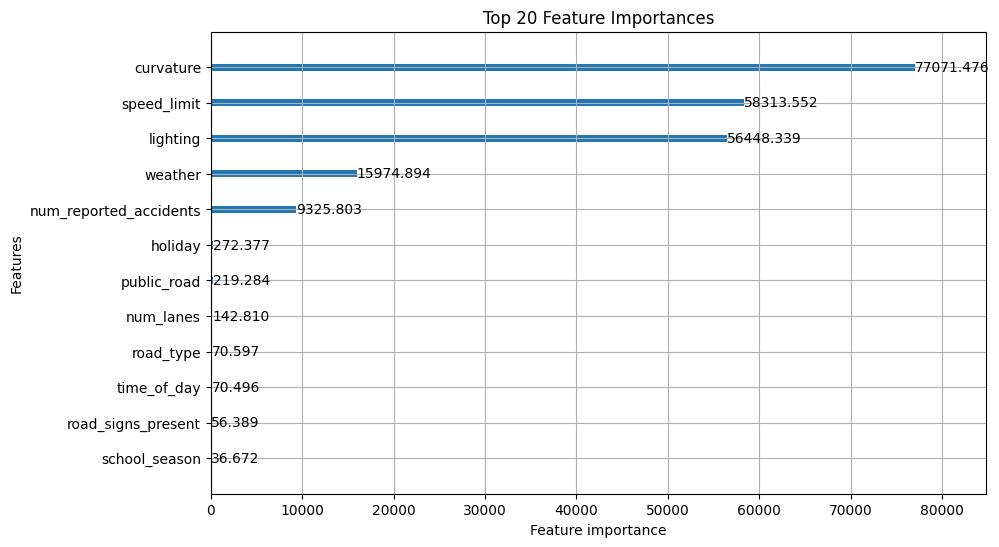

In [8]:
lgb.plot_importance(final_model, max_num_features=20, importance_type="gain", figsize=(10,6))
plt.title("Top 20 Feature Importances")
plt.show()

## ✅ Summary
- Preprocessed categorical and numerical features  
- LightGBM with 5-fold CV  
- Baseline RMSE printed and submission file generated  

This provides a foundation to iterate on feature engineering, model tuning, or ensembling.